In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_parquet("flights_clean_feature_engineered.parquet")

print(df.shape)
df.head()

(7061581, 77)


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,taxi_out_winsor,taxi_in_cap,taxi_in_outlier_flag,taxi_in_winsor,taxi_total_cap,taxi_total_outlier_flag,taxi_total_winsor,excess_elapsed_time_cap,excess_elapsed_time_outlier_flag,excess_elapsed_time_winsor
0,2024,1,1,1,2024-01-01,9E,4814,JFK,NY,New York,...,31.0,37.0,0,7.0,93.0,0,38.0,54.00,0,-14.0
1,2024,1,1,1,2024-01-01,9E,4815,MSP,MN,Minnesota,...,20.0,35.0,0,6.0,71.0,0,26.0,42.00,0,-16.0
2,2024,1,1,1,2024-01-01,9E,4817,JFK,NY,New York,...,21.0,37.0,0,8.0,93.0,0,29.0,54.00,0,-16.0
3,2024,1,1,1,2024-01-01,9E,4817,RIC,VA,Virginia,...,13.0,35.0,0,12.0,69.0,0,25.0,42.11,0,-35.0
4,2024,1,1,1,2024-01-01,9E,4818,DTW,MI,Michigan,...,21.0,36.0,0,4.0,68.0,0,25.0,39.00,0,-9.0


## 1. Time & Calendar Features EDA
### 1.1 Flights by day of week

In [2]:
df.groupby('day_name')['dep_delay'].agg(['mean','median','std','count'])

,mean,median,std,count
day_name,,,,
Friday,14.589304,-2.0,57.480808,1037087
Monday,12.638753,-2.0,57.076282,1056398
Saturday,12.511694,-2.0,55.759963,898255
Sunday,14.280468,-2.0,57.913455,1029370
Thursday,13.083721,-2.0,55.387123,1024394
Tuesday,10.360308,-3.0,53.780124,961064
Wednesday,10.333572,-3.0,52.636451,958699


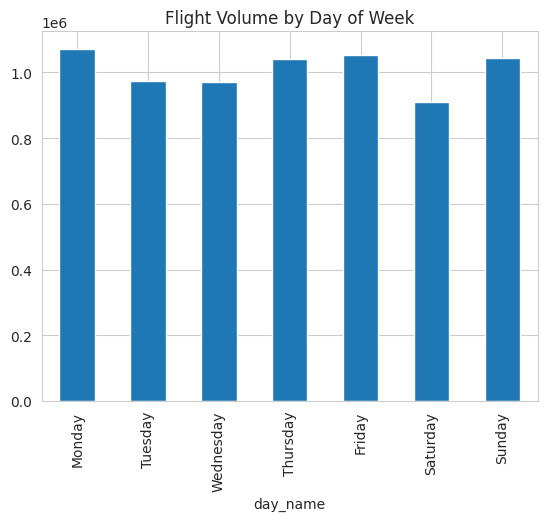

In [3]:
df['day_name'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar')
plt.title("Flight Volume by Day of Week")
plt.show()

### 1.2 Avg departure delay by hour

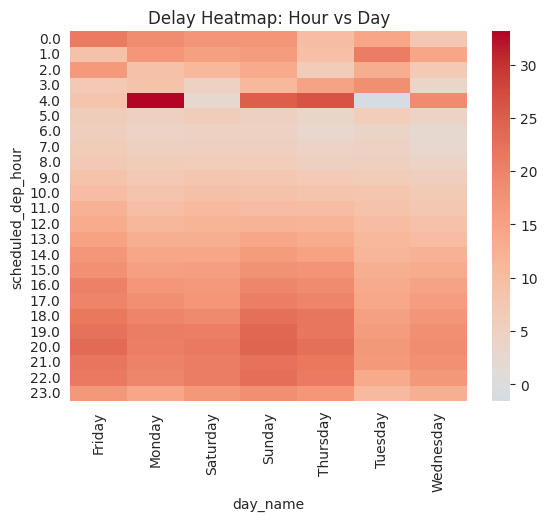

In [4]:
sns.heatmap(df.pivot_table(values='dep_delay',
                           index='scheduled_dep_hour',
                           columns='day_name',
                           aggfunc='mean'),
            cmap='coolwarm', center=0)
plt.title("Delay Heatmap: Hour vs Day")
plt.show()

###1.3 Weekend vs weekday delay

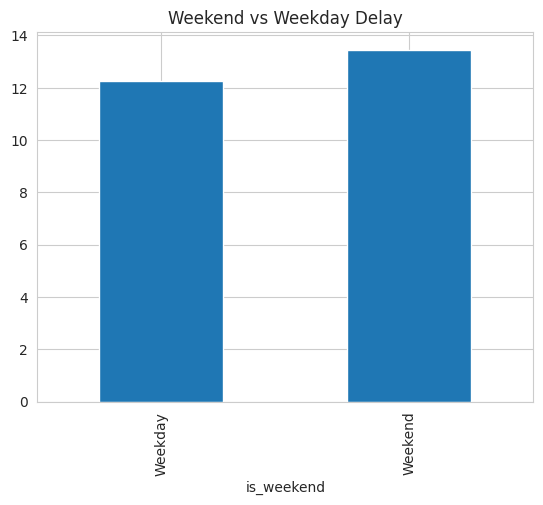

In [5]:
df.groupby('is_weekend')['dep_delay'].mean().plot(kind='bar')
plt.title("Weekend vs Weekday Delay")
plt.xticks([0,1], ['Weekday','Weekend'])
plt.show()

###1.4 Seasonal cancellation rate

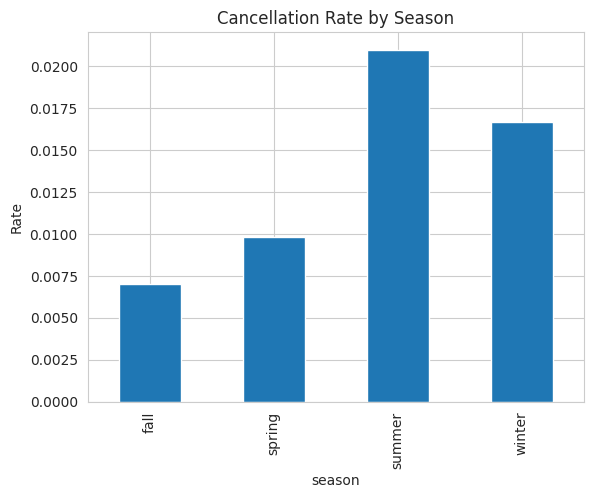

In [6]:
df.groupby('season')['cancelled'].mean().plot(kind='bar')
plt.title("Cancellation Rate by Season")
plt.ylabel("Rate")
plt.show()

##2. Delay Outcome Features EDA
###2.1 Distribution of delays

In [7]:
df[['dep_delay','arr_delay']].describe()

,dep_delay,arr_delay
count,6.965267e+06,6.965267e+06
mean,1.258919e+01,7.098245e+00
std,5.582751e+01,5.799127e+01
min,-9.600000e+01,-1.260000e+02
25%,-6.000000e+00,-1.500000e+01
50%,-2.000000e+00,-6.000000e+00
75%,9.000000e+00,9.000000e+00
max,3.777000e+03,3.803000e+03


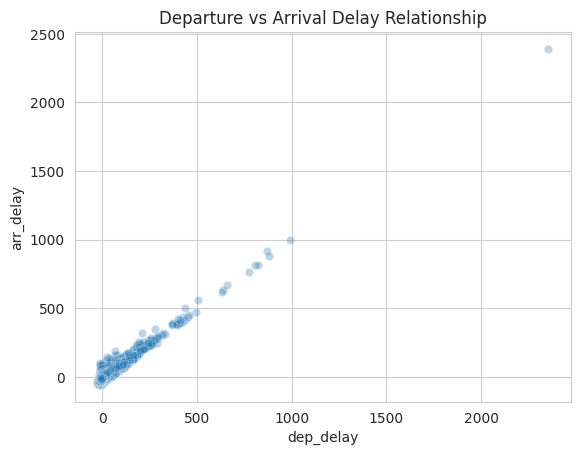

In [8]:
sns.scatterplot(x='dep_delay', y='arr_delay', data=df.sample(8000), alpha=0.3)
plt.title("Departure vs Arrival Delay Relationship")
plt.show()

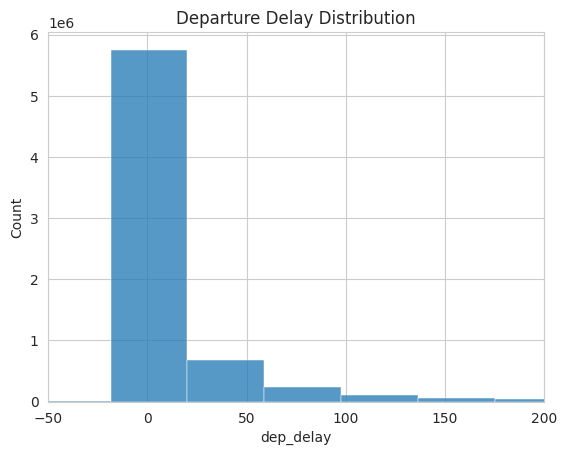

In [9]:
sns.histplot(df['dep_delay'], bins=100)
plt.xlim(-50,200)
plt.title("Departure Delay Distribution")
plt.show()

###2.2 Delay bucket share

In [10]:
df.groupby('delay_bucket')['arr_delay'].agg(['mean','count'])

,mean,count
delay_bucket,,
extreme,338.299654,99468
major,100.783419,403263
minor,31.981541,900657
on_time,-9.646999,5561879
unknown,NaN,0


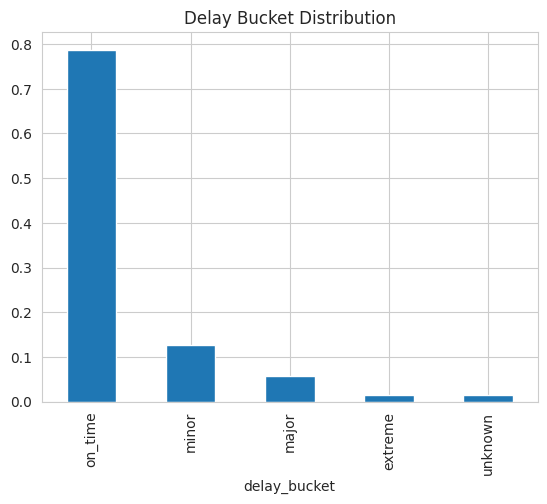

In [11]:
bucket_share = df['delay_bucket'].value_counts(normalize=True)
bucket_share.plot(kind='bar')
plt.title("Delay Bucket Distribution")
plt.show()

###2.3 Carrier delay comparison

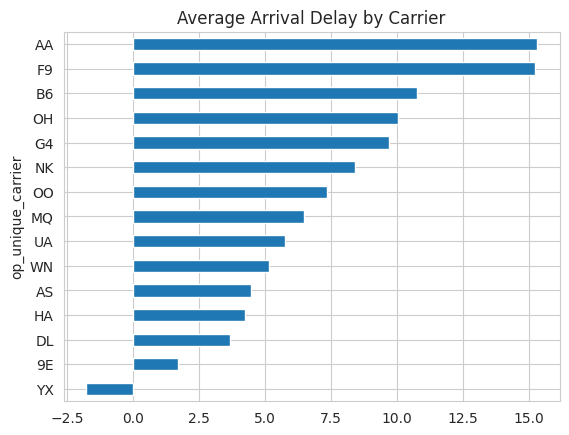

In [12]:
carrier_delay = df.groupby('op_unique_carrier')['arr_delay'].mean().sort_values()
carrier_delay.plot(kind='barh')
plt.title("Average Arrival Delay by Carrier")
plt.show()

##3. Operational Efficiency EDA
###3.1 Taxi time vs delay

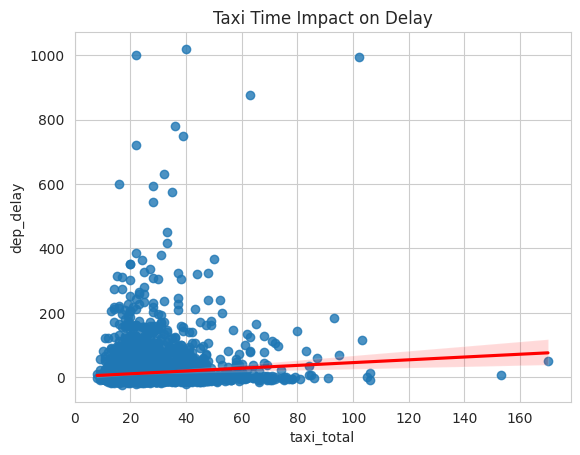

In [13]:
sns.regplot(
    x='taxi_total',
    y='dep_delay',
    data=df.sample(5000),
    line_kws={'color': 'red'}
)
plt.title("Taxi Time Impact on Delay")
plt.show()

###3.2 Schedule padding distribution

In [14]:
df[['taxi_out','taxi_in','taxi_total','schedule_padding']].describe()

,taxi_out,taxi_in,taxi_total,schedule_padding
count,6.965267e+06,6.965267e+06,6.965267e+06,6.965267e+06
mean,1.789673e+01,8.318710e+00,2.621544e+01,3.170614e+01
std,9.664173e+00,6.821766e+00,1.191039e+01,1.056666e+01
min,1.000000e+00,1.000000e+00,2.000000e+00,-6.300000e+02
25%,1.200000e+01,5.000000e+00,1.900000e+01,2.500000e+01
50%,1.500000e+01,6.000000e+00,2.400000e+01,3.100000e+01
75%,2.100000e+01,1.000000e+01,3.000000e+01,3.800000e+01
max,2.140000e+02,4.440000e+02,5.000000e+02,8.050000e+02


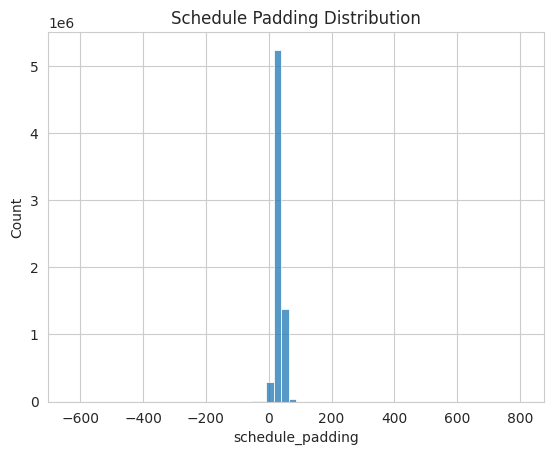

In [15]:
sns.histplot(df['schedule_padding'], bins=60)
plt.title("Schedule Padding Distribution")
plt.show()

###3.3 Air speed sanity check

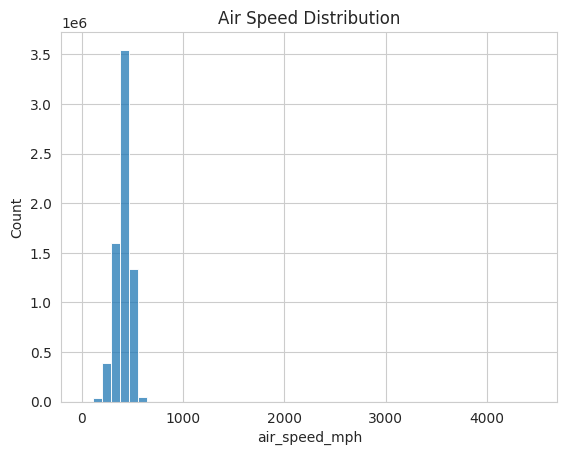

In [16]:
sns.histplot(df['air_speed_mph'], bins=50)
plt.title("Air Speed Distribution")
plt.show()

In [17]:
corr_dep = df['air_speed_mph'].corr(df['dep_delay'])
corr_arr = df['air_speed_mph'].corr(df['arr_delay'])

print("Correlation (air speed vs dep delay):", corr_dep)
print("Correlation (air speed vs arr delay):", corr_arr)

Correlation (air speed vs dep delay): 0.018391599045303762
Correlation (air speed vs arr delay): -0.041440942614413154


##4. Airport Baseline Context EDA
###4.1 Top congested origin airports

In [18]:
df.groupby('origin')[['origin_avg_dep_delay']].agg(['mean','count']).sort_values(('origin_avg_dep_delay','mean'), ascending=False).head(10)

origin_avg_dep_delay      
                       mean count
origin                           
MGW               72.621622    37
EWN               68.404255    51
HTS               42.788835   426
SMX               40.509434   106
CKB               37.024752   207
OTH               35.424779   343
HGR               35.265734   295
PBG               27.609603   499
HYA               26.290698   267
DEC               26.203947   778

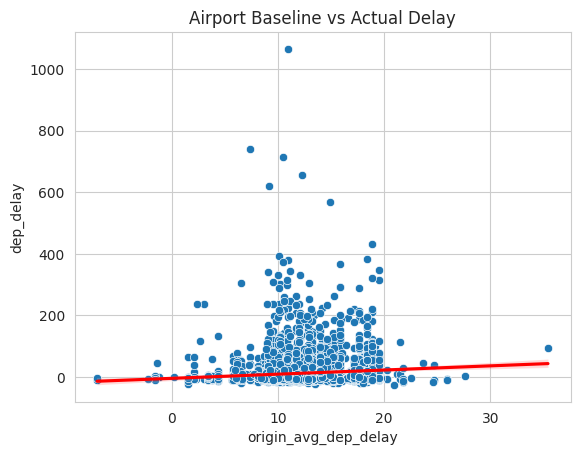

In [19]:
sns.scatterplot(x='origin_avg_dep_delay', y='dep_delay', data=df.sample(5000))
sns.regplot(x='origin_avg_dep_delay', y='dep_delay', data=df.sample(5000), scatter=False, color='red')
plt.title("Airport Baseline vs Actual Delay")
plt.show()

###4.2 Flights worse than airport baseline

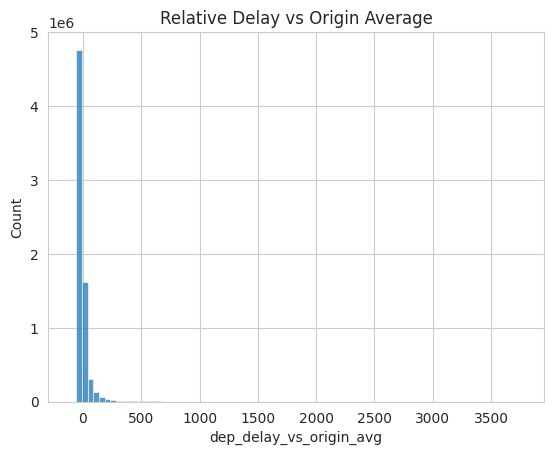

In [20]:
sns.histplot(df['dep_delay_vs_origin_avg'], bins=80)
plt.title("Relative Delay vs Origin Average")
plt.show()

In [21]:
df[df['dep_delay_vs_origin_avg'] > 120].head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,taxi_out_winsor,taxi_in_cap,taxi_in_outlier_flag,taxi_in_winsor,taxi_total_cap,taxi_total_outlier_flag,taxi_total_winsor,excess_elapsed_time_cap,excess_elapsed_time_outlier_flag,excess_elapsed_time_winsor
54,2024,1,1,1,2024-01-01,9E,4932,CLT,NC,North Carolina,...,26.0,32.0,0,5.0,69.0,0,31.0,41.0,0,-16.0
239,2024,1,1,1,2024-01-01,9E,5216,RDU,NC,North Carolina,...,17.0,39.0,0,4.0,74.0,0,21.0,46.0,0,-30.0
244,2024,1,1,1,2024-01-01,9E,5225,AVL,NC,North Carolina,...,22.0,41.0,0,10.0,70.0,0,32.0,43.0,0,-6.0
433,2024,1,1,1,2024-01-01,AA,1058,ROC,NY,New York,...,25.0,40.0,0,12.0,67.0,0,37.0,37.0,0,-7.0
485,2024,1,1,1,2024-01-01,AA,1119,MIA,FL,Florida,...,40.0,39.0,0,4.0,79.0,0,44.0,50.0,0,17.0


##5. Route-Level EDA
###5.1 Distance bucket delay

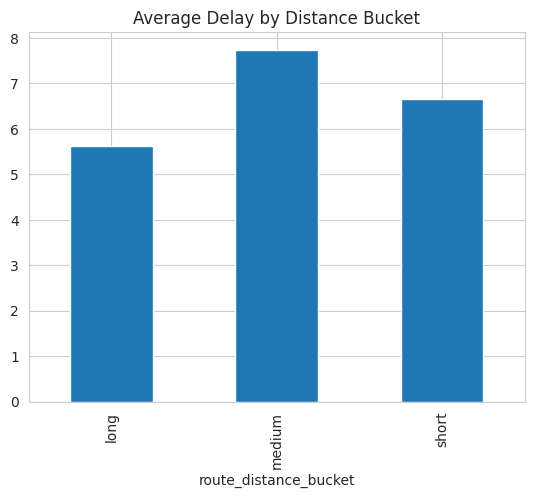

In [22]:
df.groupby('route_distance_bucket')['arr_delay'].mean().plot(kind='bar')
plt.title("Average Delay by Distance Bucket")
plt.show()

###5.2 High-risk routes

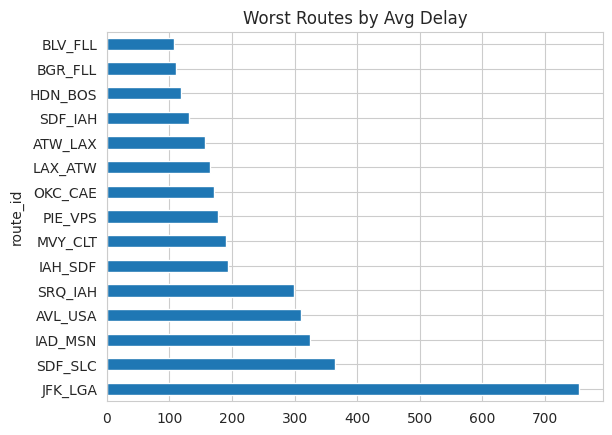

In [23]:
route_risk = df.groupby('route_id')['arr_delay'].mean().sort_values(ascending=False).head(15)
route_risk.plot(kind='barh')
plt.title("Worst Routes by Avg Delay")
plt.show()

###5.3 Route volume vs delay

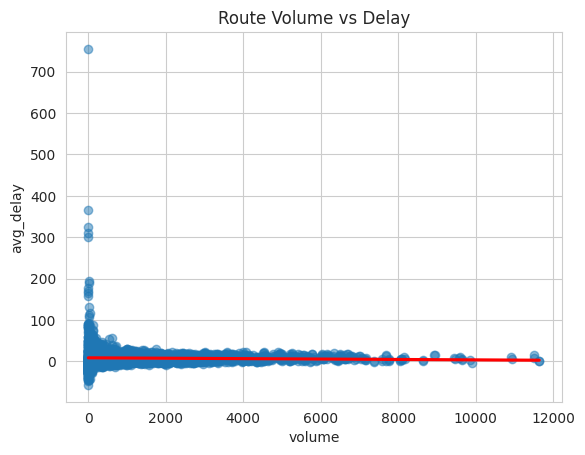

In [31]:
sns.regplot(data=route_stats, x='volume', y='avg_delay',
            scatter_kws={'alpha':0.5},
            line_kws={'color':'red'})
plt.title("Route Volume vs Delay")
plt.show()

##6. Carrier Behavior EDA
###6.1 Carrier average delay

In [25]:
df.groupby('op_unique_carrier')['arr_delay'].agg(['mean','median','std','count'])

,mean,median,std,count
op_unique_carrier,,,,
9E,1.681912,-11.0,56.256385,195072
AA,15.307916,-4.0,83.903851,966116
AS,4.467858,-4.0,36.050577,240323
B6,10.739642,-6.0,65.104532,235683
DL,3.657075,-8.0,52.542974,997846
F9,15.247771,-4.0,73.623023,203482
G4,9.710381,-8.0,79.485541,114882
HA,4.246661,-1.0,36.543874,77633
MQ,6.457716,-6.0,48.928181,275317


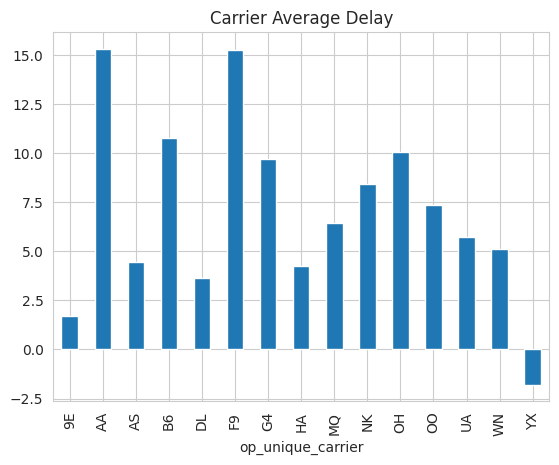

In [26]:
df.groupby('op_unique_carrier')['carrier_avg_arr_delay'].mean().plot(kind='bar')
plt.title("Carrier Average Delay")
plt.show()

###6.2 Carrier performance by airport

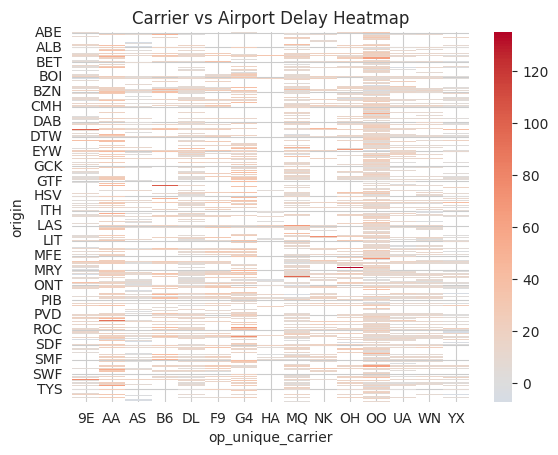

In [27]:
pivot = df.pivot_table(values='dep_delay',
                       index='origin',
                       columns='op_unique_carrier',
                       aggfunc='mean')

sns.heatmap(pivot, cmap='coolwarm', center=0)
plt.title("Carrier vs Airport Delay Heatmap")
plt.show()

##7. Delay Attribution EDA
###7.1 Share of delay causes

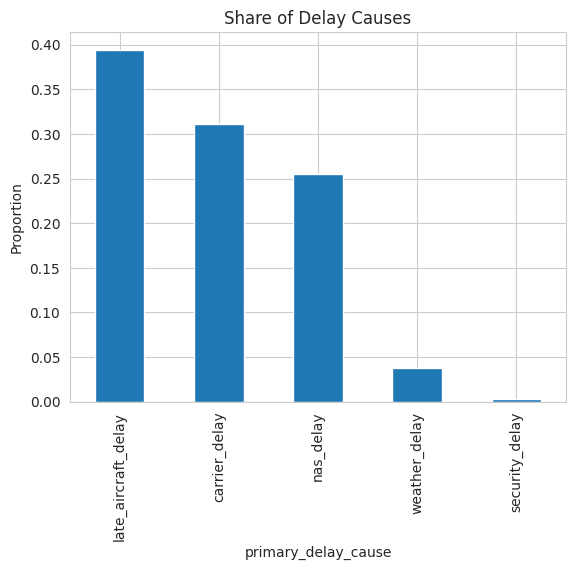

In [28]:
df['primary_delay_cause'].value_counts(normalize=True).plot(kind='bar')
plt.title("Share of Delay Causes")
plt.ylabel("Proportion")
plt.show()

###7.2 Weather delay by season

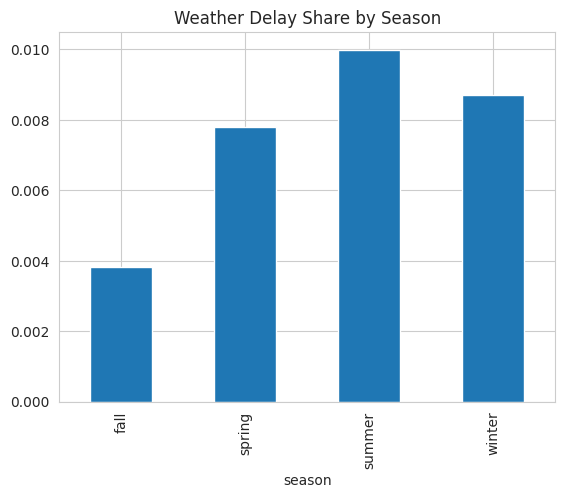

In [29]:
df.groupby('season')['weather_delay_share'].mean().plot(kind='bar')
plt.title("Weather Delay Share by Season")
plt.show()

##8. Outlier
###8.1 Outlier rate summary

In [30]:
summary = []

outlier_flag_cols = [col for col in df.columns if col.endswith('_outlier_flag')]

cols = [col.replace('_outlier_flag', '') for col in outlier_flag_cols]

for col in cols:
    summary.append({
        "feature": col,
        "outlier_rate": df[f"{col}_outlier_flag"].mean()
    })

pd.DataFrame(summary)

,feature,outlier_rate
0,taxi_out,0.009503
1,taxi_in,0.009445
2,taxi_total,0.009588
3,excess_elapsed_time,0.009570
